<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#data-loading-and-train-test-split" data-toc-modified-id="data-loading-and-train-test-split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>data loading and train test split</a></span></li><li><span><a href="#Composition-model" data-toc-modified-id="Composition-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Composition model</a></span><ul class="toc-item"><li><span><a href="#default" data-toc-modified-id="default-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>default</a></span></li><li><span><a href="#Try-different-regression-models-(without-parameter-optimization)" data-toc-modified-id="Try-different-regression-models-(without-parameter-optimization)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Try different regression models (without parameter optimization)</a></span></li><li><span><a href="#test-case:-Si,-Ge,-Si49Ge51" data-toc-modified-id="test-case:-Si,-Ge,-Si49Ge51-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>test case: Si, Ge, Si49Ge51</a></span></li></ul></li><li><span><a href="#Structure-model" data-toc-modified-id="Structure-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Structure model</a></span><ul class="toc-item"><li><span><a href="#default" data-toc-modified-id="default-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>default</a></span></li><li><span><a href="#Try-different-regression-models-(without-parameter-optimization)" data-toc-modified-id="Try-different-regression-models-(without-parameter-optimization)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Try different regression models (without parameter optimization)</a></span></li></ul></li><li><span><a href="#Self-evaluation" data-toc-modified-id="Self-evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Self-evaluation</a></span><ul class="toc-item"><li><span><a href="#Accomplishment" data-toc-modified-id="Accomplishment-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><font color="green">Accomplishment</font></a></span></li><li><span><a href="#Drawbacks" data-toc-modified-id="Drawbacks-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><font color="red">Drawbacks</font></a></span></li><li><span><a href="#To-dos" data-toc-modified-id="To-dos-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span><font color="blue">To-dos</font></a></span></li><li><span><a href="#Side-comment" data-toc-modified-id="Side-comment-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span><font color="Brown">Side comment</font></a></span></li></ul></li></ul></div>

In [1]:
from monty.serialization import loadfn
from pymatgen.core import Structure
from rewotesMLpredictor.featurizer import CompositionFeaturizer, StructureFeaturizer
from rewotesMLpredictor.predictor import Predictor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Lasso, SGDRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# data loading and train test split

In [2]:
data_MP_Bandgap = loadfn("MP_789_bandgap.json")

In [3]:
data_MP_Bandgap_train, data_MP_Bandgap_test = train_test_split(
    data_MP_Bandgap, test_size=0.1, train_size=0.9, random_state=42, shuffle=True)
print(f"We have {len(data_MP_Bandgap_train)} training data and {len(data_MP_Bandgap_test)} test data.")


We have 710 training data and 79 test data.


In [4]:
structures_train = [d['structure'] for d in data_MP_Bandgap_train]
compositions_train = [s.composition for s in structures_train]
bandgap_MP_train = [d['band_gap'] for d in data_MP_Bandgap_train]

structures_test = [d['structure'] for d in data_MP_Bandgap_test]
compositions_test = [s.composition for s in structures_test]
bandgap_MP_test = [d['band_gap'] for d in data_MP_Bandgap_test]

# Composition model

## default

In [5]:
predictor = Predictor(featurizer=CompositionFeaturizer())

In [6]:
%%time
predictor.fit(compositions_train, bandgap_MP_train)

CPU times: user 164 ms, sys: 503 ms, total: 667 ms
Wall time: 47.1 s


Predictor(featurizer=CompositionFeaturizer(featurizers=[ElementProperty(data_source=<matminer.utils.data.MEGNetElementData object at 0x295635700>,
                                                                        features=['embedding '
                                                                                  '1',
                                                                                  'embedding '
                                                                                  '2',
                                                                                  'embedding '
                                                                                  '3',
                                                                                  'embedding '
                                                                                  '4',
                                                                                  'embedding '
                                                                                  '5',
                                                                                  'embedding '
                                                                                  '6',
                                                                                  'embedding '
                                                                                  '7',
                                                                                  'embedding '
                                                                                  '8',
                                                                                  'embedding '
                                                                                  '9',
                                                                                  'embedding '
                                                                                  '10',
                                                                                  'embedding '
                                                                                  '11',
                                                                                  'embedding '
                                                                                  '12',
                                                                                  'embedding '
                                                                                  '13',
                                                                                  'embedding '
                                                                                  '14',
                                                                                  'embedding '
                                                                                  '15',
                                                                                  'embedding '
                                                                                  '16'],
                                                                        stats=['minimum',
                                                                               'maximum',
                                                                               'range',
                                                                               'mean',
                                                                               'std_dev'])]))

In [7]:
%%time
bandgap_MP_predicted_test = predictor.predict(compositions_test)
bandgap_MP_predicted_train = predictor.predict(compositions_train)

CPU times: user 156 ms, sys: 472 ms, total: 628 ms
Wall time: 48.4 s


In [8]:
def parity_plot(x, y, label=None):
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    plt.plot(x, y, "*", label=f"{label}MAE={mae:.2f}eV, r2={r2:.2f}", alpha=0.5)
    plt.xlabel("Band gap in MP (eV)", size=18)
    plt.ylabel("ML-predicted band gap (eV)", size=18)
    xy_max, xy_min = np.max([x,y])+1, np.min([x,y])-1
    plt.ylim(xy_min, xy_max)
    plt.xlim(xy_min, xy_max)

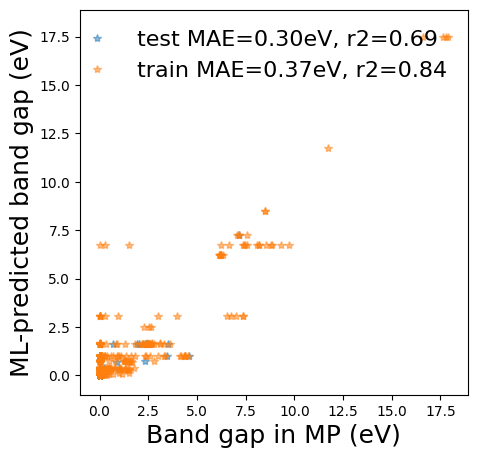

In [9]:
plt.figure(figsize=(5,5))
parity_plot(bandgap_MP_test, bandgap_MP_predicted_test, label="test ")
parity_plot(bandgap_MP_train, bandgap_MP_predicted_train, label="train ")
plt.legend(frameon=False, fontsize=16)

## Try different regression models (without parameter optimization)

<font color="red">These tests are only for POC, where cross validation and parameter optimization are skipped.</font>

In [10]:
regression_models = [BayesianRidge(), HuberRegressor(), Lasso(), SGDRegressor(), 
                     LinearSVR(), NuSVR(), DecisionTreeRegressor()]


In [11]:
%%time

predictions_train, predictions_test, predictors, MAEs, r2s = [], [], [], [], []
for model in regression_models:
    t0 = time.time()
    predictor = Predictor(featurizer=CompositionFeaturizer(), model=model)
    predictor.fit(compositions_train, bandgap_MP_train)
    predictions_train.append(predictor.predict(compositions_train))
    predictions_test.append(predictor.predict(compositions_test))
    predictors.append(predictor)
    mae = mean_absolute_error(bandgap_MP_train, predictions_train[-1]), mean_absolute_error(bandgap_MP_test, predictions_test[-1])
    r2 = r2_score(bandgap_MP_train, predictions_train[-1]), r2_score(bandgap_MP_test, predictions_test[-1])
    MAEs.append(mae)
    r2s.append(r2)
    t1 = time.time()
    print(f"\nUsed {t1-t0}s to fit and predict with {model}.",
          f" MAE={mae}, r2={r2} for training and test.")


Used 94.83247327804565s to fit and predict with BayesianRidge().  MAE=(1.0343400119315826, 0.906200085773074), r2=(0.3564487054642973, 0.04149132197153782) for training and test.

Used 100.92210721969604s to fit and predict with HuberRegressor().  MAE=(0.7372392486671339, 0.47255534040635433), r2=(-0.03254818393857151, -0.03529054268153198) for training and test.

Used 102.03430914878845s to fit and predict with Lasso().  MAE=(1.170834173378298, 0.9267929220894995), r2=(0.0, -0.05886777501435292) for training and test.

Used 104.38562893867493s to fit and predict with SGDRegressor().  MAE=(1.0286107224494985, 0.8734358648563614), r2=(0.314038090787607, 0.028251740904816525) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Used 105.63911032676697s to fit and predict with LinearSVR().  MAE=(0.7324965996389431, 0.4448846039982225), r2=(-0.10629946639018328, -0.12339627419224719) for training and test.

Used 104.5581841468811s to fit and predict with NuSVR().  MAE=(0.5163904684359325, 0.33617895475398685), r2=(0.37509899434698113, 0.5100533583596244) for training and test.

Used 102.70574688911438s to fit and predict with DecisionTreeRegressor().  MAE=(0.37025286517420936, 0.2976418371773046), r2=(0.8391542622341734, 0.6918224875377497) for training and test.
CPU times: user 4.35 s, sys: 7.52 s, total: 11.9 s
Wall time: 11min 55s


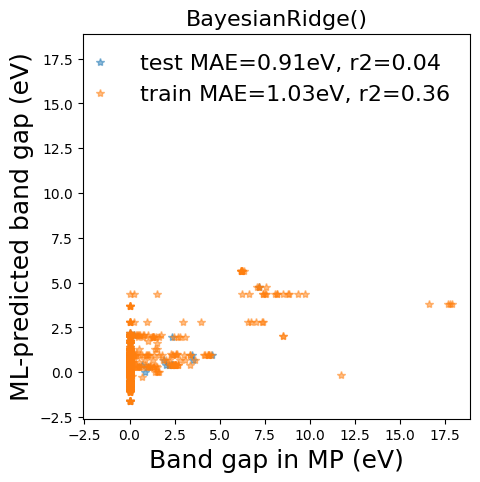

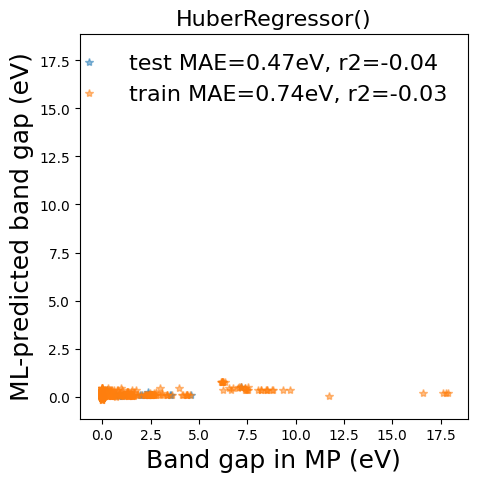

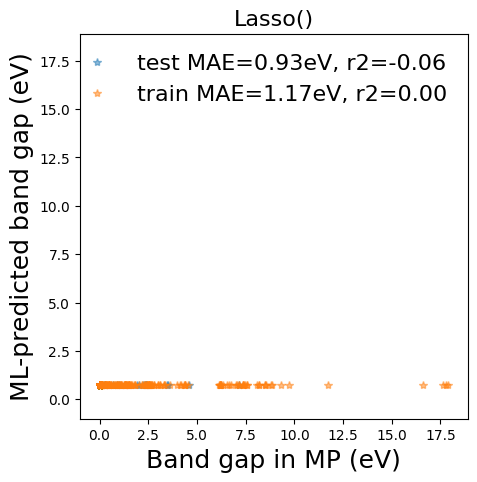

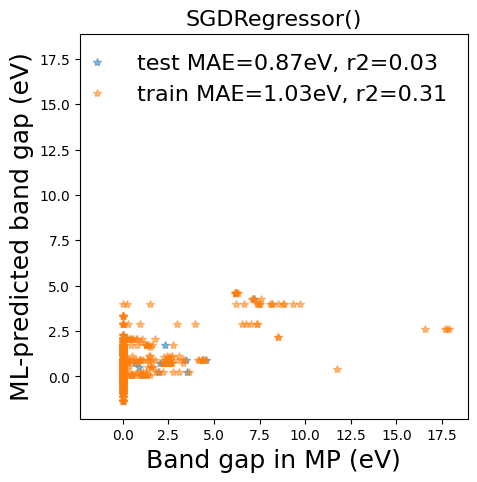

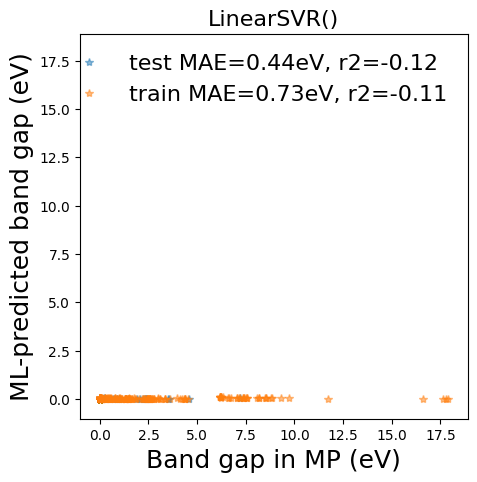

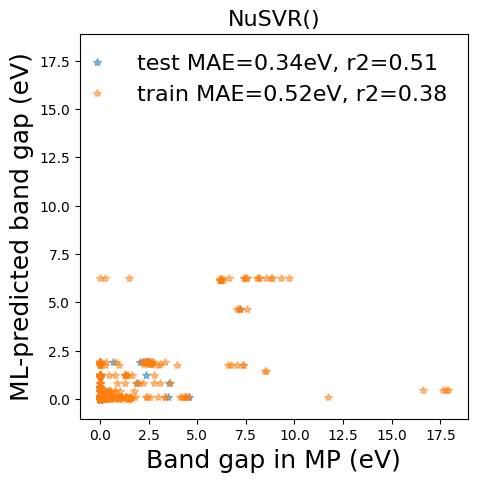

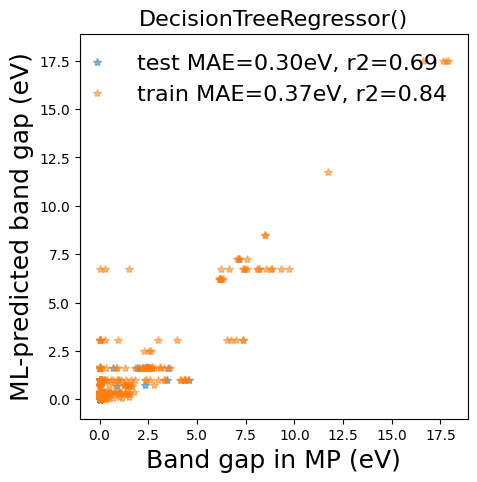

In [12]:
for i, prediction_train in enumerate(predictions_train):
    plt.figure(figsize=(5,5))
    parity_plot(bandgap_MP_test, predictions_test[i], label="test ")
    parity_plot(bandgap_MP_train, prediction_train, label="train ")
    plt.legend(frameon=False, fontsize=16)
    plt.title(regression_models[i], size=16)

## test case: Si, Ge, Si49Ge51

In [13]:
compositions = ["Si", "Ge","Ge10", "SiGe", "Si49Ge51"]
for composition in compositions:
    print(f"Predicted band gap is {predictors[-1].predict([composition])[0]:.2f}eV for {composition}")

Predicted band gap is 0.35eV for Si
Predicted band gap is 0.09eV for Ge
Predicted band gap is 0.09eV for Ge10
Predicted band gap is 0.00eV for SiGe
Predicted band gap is 0.00eV for Si49Ge51


# Structure model

## default 

In [14]:
predictor = Predictor(featurizer=StructureFeaturizer())

In [15]:
SF = StructureFeaturizer()

In [16]:
%%time
predictor.fit(structures_train, bandgap_MP_train)

CPU times: user 18.4 s, sys: 2.32 s, total: 20.7 s
Wall time: 14.7 s


Predictor()

In [17]:
%%time
bandgap_MP_predicted_test = predictor.predict(structures_test)
bandgap_MP_predicted_train = predictor.predict(structures_train)

CPU times: user 20.2 s, sys: 2.49 s, total: 22.6 s
Wall time: 16.4 s


In [18]:
def parity_plot(x, y, label=None):
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    plt.plot(x, y, "*", label=f"{label}MAE={mae:.2f}eV, r2={r2:.2f}", alpha=0.5)
    plt.xlabel("Band gap in MP (eV)", size=18)
    plt.ylabel("ML-predicted band gap (eV)", size=18)
    xy_max, xy_min = np.max([x,y])+1, np.min([x,y])-1
    plt.ylim(xy_min, xy_max)
    plt.xlim(xy_min, xy_max)

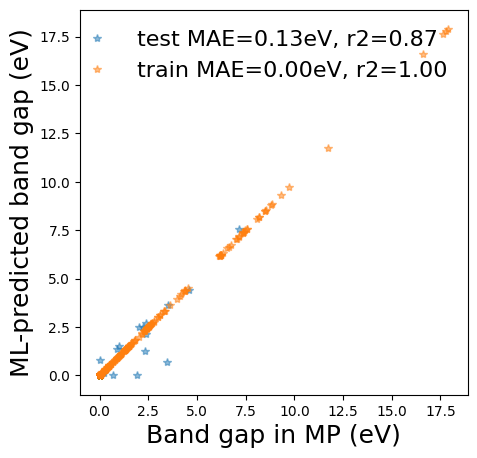

In [19]:
plt.figure(figsize=(5,5))
parity_plot(bandgap_MP_test, bandgap_MP_predicted_test, label="test ")
parity_plot(bandgap_MP_train, bandgap_MP_predicted_train, label="train ")
plt.legend(frameon=False, fontsize=16)

## Try different regression models (without parameter optimization)

<font color="red">These tests are only for POC, where cross validation and parameter optimization are skipped.</font>

In [20]:
from rewotesMLpredictor.featurizer import MATMINER_ELEMENT_PRESETS
from sklearn.linear_model import BayesianRidge, HuberRegressor, Lasso, SGDRegressor
from sklearn.svm import LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
import time

In [21]:
regression_models = [BayesianRidge(), HuberRegressor(), Lasso(), SGDRegressor(), 
                     LinearSVR(), NuSVR(), DecisionTreeRegressor()]


In [22]:
%%time
predictions_train, predictions_test, predictors, MAEs, r2s = [], [], [], [], []
for model in regression_models:
    t0 = time.time()
    predictor = Predictor(featurizer=StructureFeaturizer(), model=model)
    predictor.fit(structures_train, bandgap_MP_train)
    predictions_train.append(predictor.predict(structures_train))
    predictions_test.append(predictor.predict(structures_test))
    predictors.append(predictor)
    mae = mean_absolute_error(bandgap_MP_train, predictions_train[-1]), mean_absolute_error(bandgap_MP_test, predictions_test[-1])
    r2 = r2_score(bandgap_MP_train, predictions_train[-1]), r2_score(bandgap_MP_test, predictions_test[-1])
    MAEs.append(mae)
    r2s.append(r2)
    t1 = time.time()
    print(f"\nUsed {t1-t0}s to fit and predict with {model}.",
          f" MAE={mae}, r2={r2} for training and test.")


Used 32.277135133743286s to fit and predict with BayesianRidge().  MAE=(0.7961006331943244, 0.9578369137065228), r2=(0.47567269634324116, -0.9476993449937678) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Used 31.614394187927246s to fit and predict with HuberRegressor().  MAE=(0.6565132439947838, 0.5603979508834313), r2=(0.31835476708767974, 0.18121436178237982) for training and test.



Used 32.03025484085083s to fit and predict with Lasso().  MAE=(1.170834173378298, 0.9267929220894995), r2=(0.0, -0.05886777501435292) for training and test.



Used 31.598196983337402s to fit and predict with SGDRegressor().  MAE=(0.8747123408922232, 0.9280245692796102), r2=(0.3931525687169387, -0.4758678579278839) for training and test.


/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qiji/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Used 31.7725989818573s to fit and predict with LinearSVR().  MAE=(0.6703505300591378, 0.514729392710533), r2=(0.1983638285991326, 0.176579694515423) for training and test.



Used 31.80120587348938s to fit and predict with NuSVR().  MAE=(0.5284472647678449, 0.45883792051632366), r2=(0.32899690415312643, 0.245067266306781) for training and test.



Used 31.847610235214233s to fit and predict with DecisionTreeRegressor().  MAE=(4.1697881087932823e-19, 0.18470126582278482), r2=(1.0, 0.7887335147706339) for training and test.
CPU times: user 4min 53s, sys: 39.3 s, total: 5min 33s
Wall time: 3min 42s


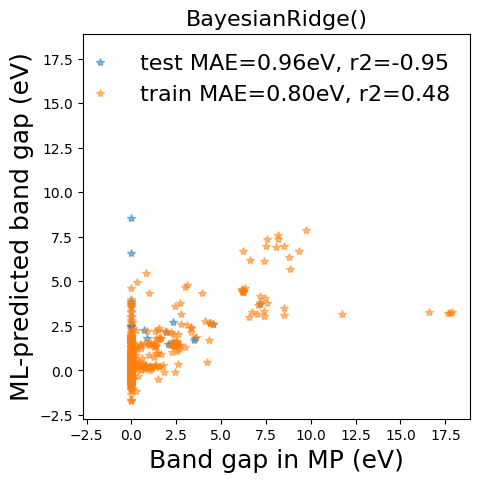

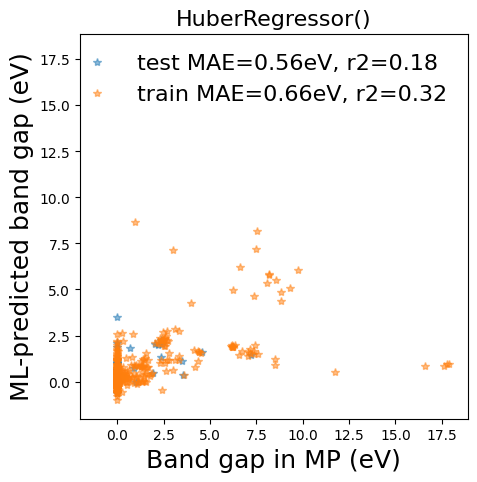

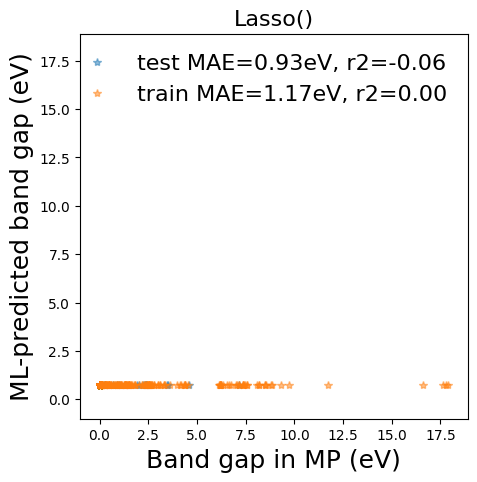

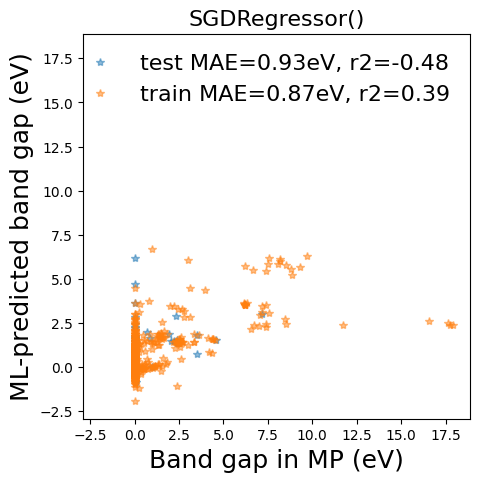

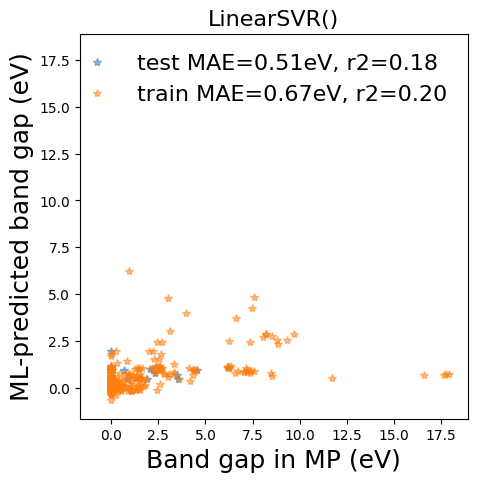

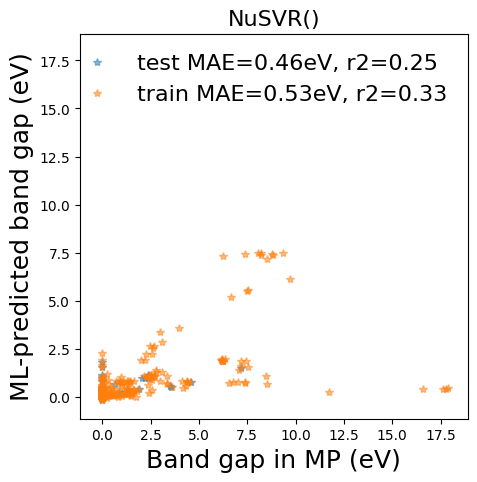

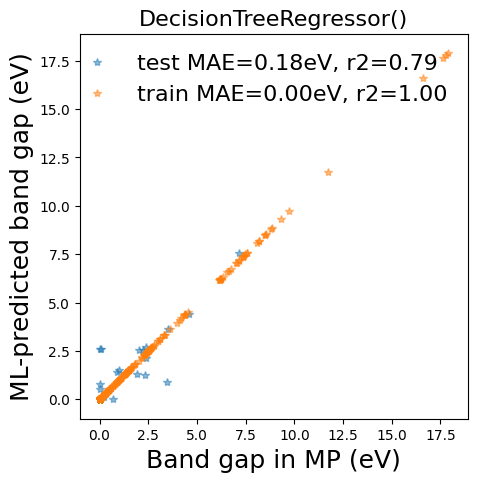

In [23]:
for i, prediction_train in enumerate(predictions_train):
    plt.figure(figsize=(5,5))
    parity_plot(bandgap_MP_test, predictions_test[i], label="test ")
    parity_plot(bandgap_MP_train, prediction_train, label="train ")
    plt.legend(frameon=False, fontsize=16)
    plt.title(regression_models[i], size=16)

# Self-evaluation

## <font color="green">Accomplishment</font>

1. Implemented a python package for materials property predictions from composition or structure.
2. Documented the package.
3. Gave an example of usage that meets the requirement from Timur for the reWote.

## <font color="red">Drawbacks</font>

1. I did't complete the time limit of 5 days because of Thanksgiving and MRS.
2. No test.
3. The architecture of the package can be more extendable, e.g., more features and parameter tuning should be allowed.

## <font color="blue">To-dos</font>

1. Design better software structures.
2. Add tests.


## <font color="Brown">Side comment</font>

This is my first time to implement a python package from scratch. It is very easy to make it work but not simple to come up with an optimal software architecture. Overall, this task is not too difficult thanks to so many ML for Materials Science codes out there.